# Abundance Profiles

In [24]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import scipy.stats as ss
import yaml

In [6]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.settings import Settings
from auriga.parser import parse

In [40]:
figure_setup()
settings = Settings()

In [8]:
CONFIG_FILE: str = "02"
SIMULATION: str = "au6_or_l4_s127"
SIMULATIONS: list = [f"au{i}_or_l4_s127" for i in settings.groups["Included"]]
AGE_RANGES: list = [(2 * i, 2 * i + 2) for i in range(7)]


In [9]:
CONFIG = yaml.safe_load(open(f"../configs/{CONFIG_FILE}.yml"))

In [21]:
def read_data(simulation: str, config: dict,
              abundances: tuple) -> pd.DataFrame:
    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_stellar_age()
    s.tag_particles_by_region(
        disc_std_circ=config["DISC_STD_CIRC"],
        disc_min_circ=config["DISC_MIN_CIRC"],
        cold_disc_delta_circ=config["COLD_DISC_DELTA_CIRC"],
        bulge_max_specific_energy=config["BULGE_MAX_SPECIFIC_ENERGY"])

    for abundance in abundances:
        s.add_metal_abundance(of=abundance[0], to=abundance[1])

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)
    mask = is_main_obj & is_real_star

    props = {
        "CylindricalRadius_ckpc": s.rho[mask],
        "ComponentTag": s.region_tag[mask],
        "StellarAge_Gyr": s.stellar_age[mask]}
    
    for abundance in abundances:
        of, to = abundance
        props[f"[{of}/{to}]"] = s.metal_abundance[f"{of}/{to}"][mask]

    df = pd.DataFrame(props)
    df[~np.isfinite(df)] = np.nan
    df.dropna(inplace=True)
    return df

In [11]:
def get_mask(df: pd.DataFrame,
             component: str = None,
             age_range: tuple = (0.0, 14.0)) -> pd.Series:
    settings = Settings()
    is_age = (df["StellarAge_Gyr"] >= age_range[0]) \
        & (df["StellarAge_Gyr"] <= age_range[1])
    is_component = np.ones(is_age.shape, dtype="bool")
    if component is not None:
        is_component = df["ComponentTag"] == settings.component_tags[component]
    mask = is_age & is_component 
    return mask

## [Fe/H] Profile By Stellar Age

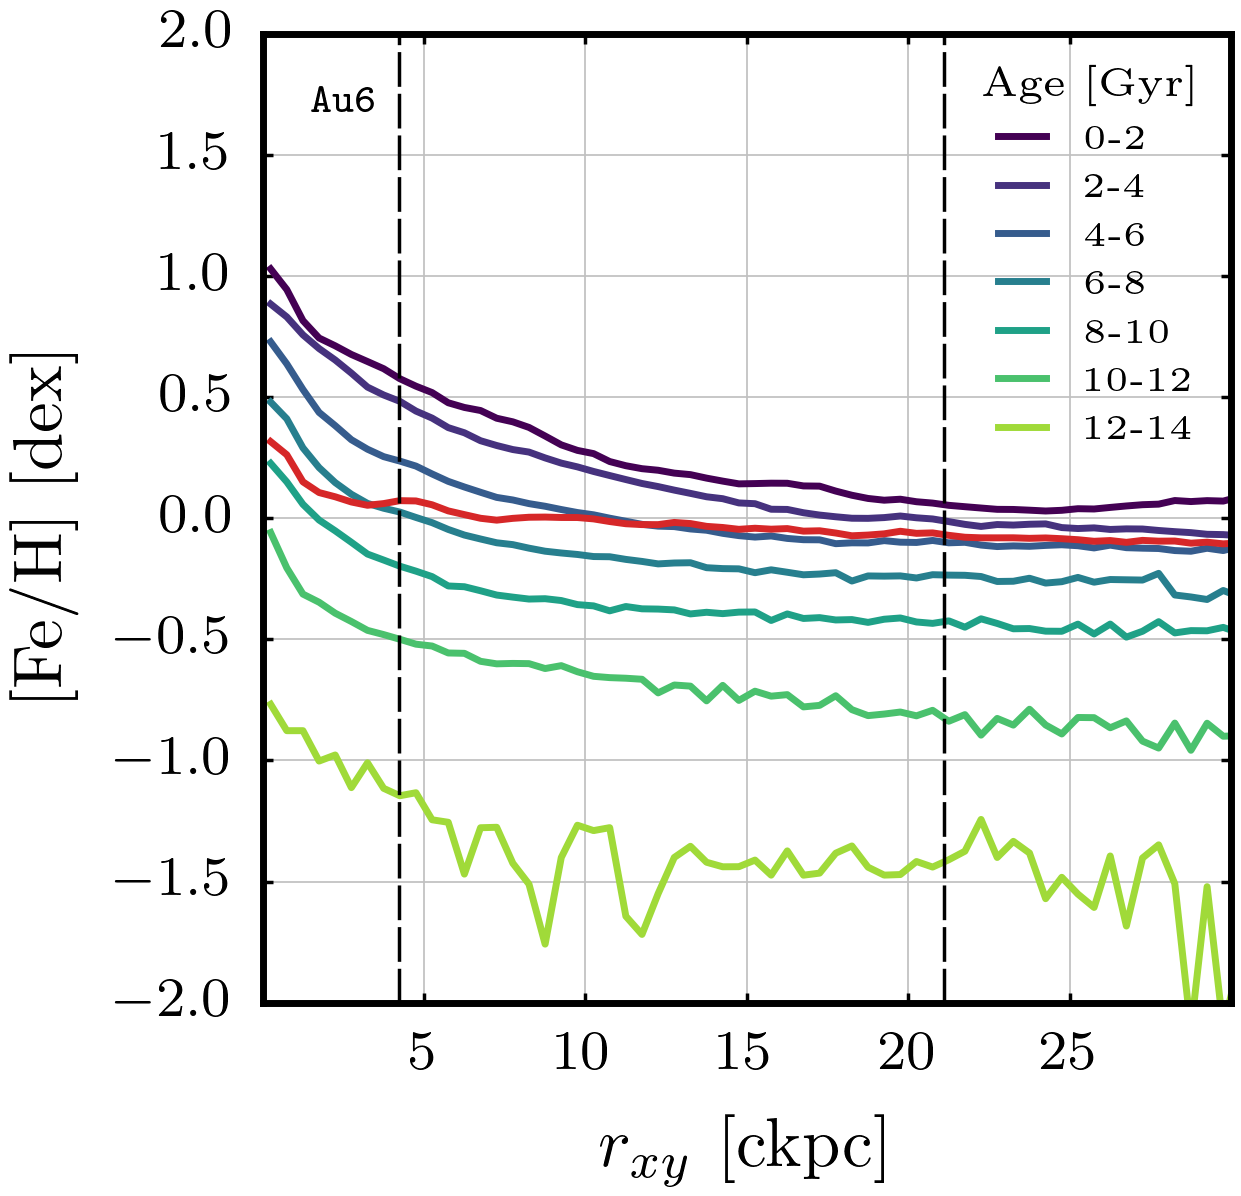

In [48]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, ls='-', lw=0.25, c='silver')

ax.set_xlim(0, 30)
ax.set_xticks([5, 10, 15, 20, 25])
ax.set_xlabel(r"$r_{xy}$ [ckpc]")

ax.set_ylim(-2, 2)
ax.set_ylabel(r"[Fe/H] [dex]")

galaxy = parse(SIMULATION)[0]
label = f"Au{galaxy}"
# df = read_data(simulation=SIMULATION, config=CONFIG, abundances=[("Fe", "H")])

for i, age_range in enumerate(AGE_RANGES):
    mask = get_mask(df, component="CD", age_range=age_range)
    stat, bin_edges, _ = ss.binned_statistic(
        x=df["CylindricalRadius_ckpc"][mask], values=df["[Fe/H]"][mask],
        statistic=np.nanmean, bins=100, range=(0.0, 50.0))
    bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
    ax.plot(bin_centers, stat, color=plt.cm.viridis(age_range[0] / 14),
            label=f"{age_range[0]}-{age_range[1]}")

# region All Stars
mask = get_mask(df, component="CD")
stat, bin_edges, _ = ss.binned_statistic(
    x=df["CylindricalRadius_ckpc"][mask], values=df["[Fe/H]"][mask],
    statistic=np.nanmean, bins=100, range=(0.0, 50.0))
bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
ax.plot(bin_centers, stat, color=settings.component_colors["CD"])
# endregion

# region Disc Radius Indication
gal_data = pd.read_csv("../data/iza_2022.csv")
disc_radius = gal_data["DiscRadius_kpc"][gal_data["Galaxy"] == galaxy]
disc_radius = disc_radius.values[0]
ax.plot([disc_radius] * 2, ax.get_ylim(), ls=(0, (5, 1)), c='k', lw=0.5)
ax.plot([0.2 * disc_radius] * 2, ax.get_ylim(), ls=(0, (5, 1)), c='k', lw=0.5)
# endregion

ax.legend(loc="upper right", title="Age [Gyr]", fontsize=5.0, framealpha=0,
          title_fontsize=6.0)

ax.text(x=0.05, y=0.95, s=r"$\texttt{" + label + "}$",
        size=6.0, transform=ax.transAxes, ha='left', va='top')

plt.show()